In [1]:
# 무한출력용 코드
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)  # 한 줄에 다 안보이면_

ModuleNotFoundError: No module named 'pandas'

In [490]:
import pandas as pd

# Load the uploaded Excel file to inspect its structure and contents
file_path = "./Deepcatch 2025-1-14_mod.xlsx"
df = pd.read_excel(file_path, na_values=["", "NaN"], keep_default_na=False, header=2)

# Display sheet names to understand the structure of the Excel file
df.columns.to_list()

['index',
 '(실명)등록번호',
 '생년월일',
 '성별',
 '병리진단',
 'Steatosis score',
 'Fibrosis stage',
 'Ballooning/Inflammation Score',
 'NAFLD Type',
 'Smoking',
 'HCC',
 'HCC_date',
 'LRE',
 'LRE_date',
 'Ascites',
 'Ascites_Date',
 'Varix bleeding',
 'VB_date',
 'HEP',
 'HEP_date',
 'HRS',
 'HRS_date',
 'LT',
 'LT_date',
 '사망일자',
 'CT_B date_baseline',
 'FS_date_baseline',
 'LSM_baseline',
 'CAP_baseline',
 'AST_baseline',
 'ALT_baseline',
 'T.bil_baseline',
 'PLT_baseline',
 'PT INR_baseline',
 'Alb_baseline',
 'Glucose_baseline',
 'HbA1c_baseline',
 'eGFR_baseline',
 'T.chol_baseline',
 'HDL_baseline',
 'LDL_baseline',
 'TG_baseline',
 'Weight_baseline',
 'Height_baseline',
 'BMI_baseline',
 'SBP (수축기 혈압) mmHg',
 'SBP (수축기 혈압)_date',
 'DBP (이완기 혈압) mmHg',
 'DBP (이완기 혈압)_date',
 'Waist (허리 둘레 cm)',
 'Waist (허리 둘레 cm)_date',
 '음주 여부',
 '술의 종류',
 '1회 음주량 (잔 혹은 병)',
 '음주 횟수 (회/주)',
 'CT_1y date',
 'FS_date_1y',
 'LSM_1y',
 'CAP_1y',
 'AST_1y',
 'ALT_1y',
 'T.bil_1y',
 'PLT_1y',
 'PT INR_1y',
 'Alb_1

## dataFrame 분리


In [491]:
# 모두 NaN인 행인 dataFrame과 아닌 dataFrame을 분리
# FS 관련 컬럼 리스트
new_order = [
    "FS_date_5y",
    "FS_date_4y",
    "FS_date_3y",
    "FS_date_2y",
    "FS_date_1y",
    "FS_date_baseline",
]

# 6개 모두 NaN인 경우 → df_no_FS
df_no_FS = df[df[new_order].isnull().all(axis=1)].copy().reset_index(drop=True)

# 하나라도 값이 있는 경우 → df_FS
df_FS = df[~df[new_order].isnull().all(axis=1)].copy().reset_index(drop=True)

In [492]:
len(df_no_FS), len(df_FS)

(66, 226)

### FS_date_source 정의


In [493]:
fs_cols = [
    "FS_date_baseline",
    "FS_date_1y",
    "FS_date_2y",
    "FS_date_3y",
    "FS_date_4y",
    "FS_date_5y",
]

# NaN이 아닌 가장 첫 번째 열의 이름 추출
fs_first_nonnull = df_FS[fs_cols].notna().idxmax(axis=1)

# 열 이름에서 시점 정보만 추출
df_FS.loc[:, "FS_date_source"] = fs_first_nonnull.str.extract(
    r"FS_date[_\.]?(.*)", expand=False
)

In [494]:
df_FS["FS_date_source"].value_counts()

FS_date_source
baseline    196
1y           12
2y           10
4y            6
5y            1
3y            1
Name: count, dtype: int64

In [495]:
# LSM이라는 열을 추가해서서 LSM_{FS_date_source}의 값으로 바꿔주기
df_FS.loc[:, "LSM"] = df_FS.apply(
    lambda row: row.get(f"LSM_{row['FS_date_source']}", pd.NA), axis=1
)
df_FS.loc[:, "CAP"] = df_FS.apply(
    lambda row: row.get(f"CAP_{row['FS_date_source']}", pd.NA), axis=1
)

## 전혀 Lab검사가 없는 개수 출력


In [496]:
lab_list = [
    "AST",
    "ALT",
    "T.bil",
    "PLT",
    "PT INR",
    "Alb",
    "Glucose",
    "HbA1c",
    "eGFR",
    "T.chol",
    "HDL",
    "LDL",
    "TG",
    "Weight",
    "Height",
]

suffix_list = ["_baseline", "_1y", "_2y", "_3y", "_4y", "_5y"]

# lab_list에 대해 접미사를 붙인 6개 행이 df에서 모두 NaN인 행의 개수를 세서 lab_list별로 count 보여주기
missing_counts = []

for lab in lab_list:
    target_cols = [lab + suffix for suffix in suffix_list if lab + suffix in df.columns]
    if target_cols:
        count = df[target_cols].isna().all(axis=1).sum()
        missing_counts.append({"Lab": lab, "All_NaN_Row_Count": count})

pd.DataFrame(missing_counts).sort_values(by="All_NaN_Row_Count", ascending=False)

,Lab,All_NaN_Row_Count
11,LDL,172
7,HbA1c,138
10,HDL,66
12,TG,50
4,PT INR,10
9,T.chol,2
1,ALT,0
6,Glucose,0
5,Alb,0
3,PLT,0


In [497]:
lab_list = [
    "AST",
    "ALT",
    "T.bil",
    "PLT",
    "PT INR",
    "Alb",
    "Glucose",
    "HbA1c",
    "eGFR",
    "T.chol",
    "HDL",
    "LDL",
    "TG",
    "Weight",
    "Height",
]

temp_FS = df[~df[fs_cols].isna().all(axis=1)].copy()

suffix_list = ["_baseline", "_1y", "_2y", "_3y", "_4y", "_5y"]

# lab_list에 대해 접미사를 붙인 6개 행이 df에서 모두 NaN인 행의 개수를 세서 lab_list별로 count 보여주기
missing_counts = []

for lab in lab_list:
    target_cols = [lab + suffix for suffix in suffix_list if lab + suffix in df.columns]
    if target_cols:
        count = temp_FS[target_cols].isna().all(axis=1).sum()
        missing_counts.append({"Lab": lab, "All_NaN_Row_Count": count})
print(f"data for df_FS: {len(temp_FS)}")
pd.DataFrame(missing_counts).sort_values(by="All_NaN_Row_Count", ascending=False)

data for df_FS: 226


,Lab,All_NaN_Row_Count
11,LDL,128
7,HbA1c,103
10,HDL,34
12,TG,24
4,PT INR,9
9,T.chol,1
1,ALT,0
6,Glucose,0
5,Alb,0
3,PLT,0


In [498]:
# lab 채우는 기준 날짜를 Fibroscan과 통일

df_FS["lab_source"] = df_FS["FS_date_source"]

In [499]:
# AST값이 없는 경우들들
# 7591074 얘는 5y AST 붙이면 되고, 8211775얘는 2y AST 붙이고, 10038224 얘는 2y AST 붙이면 됨됨


df_FS.loc[114, "lab_source"] = "5y"
df_FS.loc[139, "lab_source"] = "2y"
df_FS.loc[183, "lab_source"] = "2y"

## lab 검사 lab_source에 맞게 채워넣기


In [500]:
lab_list = [
    "AST",
    "ALT",
    "T.bil",
    "PLT",
    "PT INR",
    "Alb",
    "Glucose",
    "HbA1c",
    "eGFR",
    "T.chol",
    "HDL",
    "LDL",
    "TG",
    "Weight",
    "Height",
]


# lab_source 접미사를 붙인 결과의 열을 조회해서 새로운 열을 만들고 값을 할당
for col in lab_list:
    df_FS.loc[:, col] = df_FS.apply(
        lambda row: row.get(f"{col}_{row['lab_source']}", pd.NA), axis=1
    )

In [501]:
# df_FS[lab_list] 에서 NaN인 행 개수 세기
missing_df = df_FS[lab_list].isna().sum().reset_index()
missing_df.columns = ["Column", "Missing_Count"]
missing_df = missing_df.sort_values(by="Missing_Count", ascending=False)
missing_df

,Column,Missing_Count
11,LDL,160
7,HbA1c,146
10,HDL,72
12,TG,56
4,PT INR,26
3,PLT,7
9,T.chol,5
14,Height,3
13,Weight,3
6,Glucose,0


In [502]:
# df_FS[df_FS["Weight"].isna()] 의 "(실명)등록번호"열과 "lab_source"열을 추출
df_FS.loc[df_FS["Weight"].isna(), ["(실명)등록번호", "lab_source"]]

,(실명)등록번호,lab_source
33,3256005,2y
47,4005110,4y
139,8211775,2y


In [503]:
# Weight, Height 손수 채우기

# 3256005번 환자는 60	160
# 4005110번 환자는 80	162
# 8211775번 환자는 113.4	177.4

df_FS.loc[33, "Weight"] = 60
df_FS.loc[33, "Height"] = 160

df_FS.loc[47, "Weight"] = 80
df_FS.loc[47, "Height"] = 162

df_FS.loc[139, "Weight"] = 113.4
df_FS.loc[139, "Height"] = 177.4

In [504]:
df_FS.loc[df_FS["PLT"].isna(), ["(실명)등록번호", "lab_source"]]

,(실명)등록번호,lab_source
40,3664038,1y
41,3664547,1y
47,4005110,4y
83,5675583,baseline
139,8211775,2y
172,8839759,baseline
180,10016455,baseline


In [505]:
# 3664038 383	0.91
# 3664547 206	0.93
# 4005110 baseline 374	1.07
# 5675583 3y 284 __
# 8211775 baseline 293	1.01
# 8839759 2y 288	0.95
# 10016455 은 1y로 다시 다 수정하기

df_FS.loc[40, "PLT"] = 383
df_FS.loc[40, "PT INR"] = 0.91

df_FS.loc[41, "PLT"] = 206
df_FS.loc[41, "PT INR"] = 0.93

df_FS.loc[47, "PLT"] = 374
df_FS.loc[47, "PT INR"] = 1.07

df_FS.loc[83, "PLT"] = 284

df_FS.loc[139, "PLT"] = 293
df_FS.loc[139, "PT INR"] = 1.01

df_FS.loc[172, "PLT"] = 288
df_FS.loc[172, "PT INR"] = 0.95

In [506]:
df_FS.loc[180, "FS_date_source"] = "1y"
df_FS.loc[180, "lab_source"] = "1y"

# 수정할 리스트
mod_list = [
    "AST",
    "ALT",
    "T.bil",
    "PLT",
    "PT INR",
    "Alb",
    "Glucose",
    "HbA1c",
    "eGFR",
    "T.chol",
    "HDL",
    "LDL",
    "TG",
    "Weight",
    "Height",
]

for col in mod_list:
    # index 180인 행에 대해서만
    df_FS.loc[180, col] = df_FS.loc[180, f"{col}_{df_FS.loc[180, 'lab_source']}"]

In [507]:
targets = [
    "PT INR",
    "T.chol",
    "LDL",
    "HDL",
    "HbA1c",
    "TG",
]
suffixes = ["baseline", "1y", "2y", "3y", "4y", "5y"]

# 결측치에 대해서 뭐라도 검사한 결과를 넣기

for var in targets:
    # 결측치가 없으면 스킵
    if df_FS[var].notna().all():
        continue

    alt_cols = [f"{var}_{s}" for s in suffixes if f"{var}_{s}" in df_FS.columns]
    if not alt_cols:
        continue

    fallback = df_FS[alt_cols].bfill(axis=1).iloc[:, 0]
    df_FS.loc[df_FS[var].isna(), var] = fallback[df_FS[var].isna()]

C:\Users\chona\AppData\Local\Temp\ipykernel_34472\388267993.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fallback = df_FS[alt_cols].bfill(axis=1).iloc[:, 0]


In [508]:
# 유무에 관한 열 채워넣기
categorical_cols = [
    "당뇨병/당뇨병 전단계 유무",
    "고혈압유무",
    "이상지질혈증 유무",
    "Ischemic Heart Diseae 유무",
    "Cerebrovascualr disease 유무",
    "Nephropathy 유무",
]


# lab_source 접미사를 붙인 결과의 열을 조회해서 새로운 열을 만들고 값을 할당
# ✅ 올바른 컬럼 리스트로 교체
for col in categorical_cols:
    df_FS.loc[:, col] = df_FS.apply(
        lambda row: row.get(f"{col}_{row['lab_source']}", pd.NA), axis=1
    )

In [509]:
mod_list = [
    "AST",
    "ALT",
    "T.bil",
    "PLT",
    "PT INR",
    "Alb",
    "Glucose",
    "HbA1c",
    "eGFR",
    "T.chol",
    "HDL",
    "LDL",
    "TG",
    "Weight",
    "Height",
    ##############################
    "당뇨병/당뇨병 전단계 유무",
    "고혈압유무",
    "이상지질혈증 유무",
    "Ischemic Heart Diseae 유무",
    "Cerebrovascualr disease 유무",
    "Nephropathy 유무",
]
missing_df = df_FS[mod_list].isna().sum().reset_index()
missing_df.columns = ["Column", "Missing_Count"]
missing_df = missing_df.sort_values(by="Missing_Count", ascending=False)
missing_df

,Column,Missing_Count
11,LDL,128
7,HbA1c,103
10,HDL,34
12,TG,24
4,PT INR,9
9,T.chol,1
2,T.bil,0
1,ALT,0
0,AST,0
3,PLT,0


## 이제 나머지 종속변수와 남은 값들 채우기


In [510]:
# 방법 1

# df_FS["CT_B date"] = df_FS.apply(
#     lambda row: row.get(f"CT_B date_{row['lab_source']}", pd.NaT),
#     axis=1
# )

df_FS["CT_B date"] = df_FS["CT_B date_baseline"]


df_FS["FS_date"] = df_FS.apply(
    lambda row: row.get(f"FS_date_{row['FS_date_source']}", pd.NaT), axis=1
)

In [511]:
# 쓸데없는 열 버리고 열 이름 재정의
# Rename and filter columns
columns_to_extract = {
    "(실명)등록번호": "ID",
    "성별": "Sex",
    "생년월일": "Birth Date",
    "Steatosis score": "Steatosis Score",
    "Fibrosis stage": "Fibrosis Stage",
    "NAFLD Type": "NAFLD Type",
    "사망일자": "Death Date",
    "Circumference [mm]": "Waist",  #'Waist (허리 둘레 cm)': 'Waist',
    "Last fu_date": "Last F/U",
    "Smoking": "Smoking",
    "Ascites": "Ascites",
    "Ascites_Date": "Ascites_Date",
    "Varix bleeding": "VB",
    "VB_date": "VB_Date",
    "HEP": "HEP",
    "HEP_date": "HEP_Date",
    "HRS": "HRS",
    "HRS_date": "HRS_Date",
    "LT": "LT",
    "LT_date": "LT_Date",
    ###################################
    "FS_date": "FS_date",
    "CT_B date": "CT_B date",
    ###################################
    "SBP (수축기 혈압) mmHg": "SBP",
    "DBP (이완기 혈압) mmHg": "DBP",
    "LSM": "LSM",
    "CAP": "CAP",
    "AST": "AST",
    "ALT": "ALT",
    "Weight": "Weight",
    "Height": "Height",
    "당뇨병/당뇨병 전단계 유무": "당뇨병/당뇨병 전단계 유무",
    "고혈압유무": "고혈압유무",
    "이상지질혈증 유무": "이상지질혈증 유무",
    "Ischemic Heart Diseae 유무": "Ischemic Heart Diseae 유무",
    "Cerebrovascualr disease 유무": "Cerebrovascualr disease 유무",
    "Nephropathy 유무": "Nephropathy 유무",
    ############################################# lab_list 넣기
    "AST": "AST",
    "ALT": "ALT",
    "T.bil": "T.bil",
    "PLT": "PLT",
    "PT INR": "PT INR",
    "Alb": "Alb",
    "Glucose": "Glucose",
    "HbA1c": "HbA1c",
    "eGFR": "eGFR",
    "T.chol": "T.chol",
    "HDL": "HDL",
    "LDL": "LDL",
    "TG": "TG",
    "Weight": "Weight",
    "Height": "Height",
    ######################################
    "AVF (Whole Volume)": "VFA (Volume)",
    "SF (Whole Volume)": "SFA (Volume)",
    "Muscle (Whole Volume)": "SMA (Volume)",
    "Spleen (Volume)": "Spleen (Volume)",
    "Liver (Volume)": "Liver (Volume)",
    ######################################
    "AVF (Single Area)": "VFA (Area)",
    "SF (Single Area)": "SFA (Area)",
    "Muscle (Single Area)": "SMA (Area)",
    "AVF (Single HU)": "VFA (Attenuation)",
    "SF (Single HU)": "SFA (Attenuation)",
    "Muscle (Single HU)": "SMA (Attenuation)",
    "Liver/Spleen Volume Ratio": "Liver/Spleen Volume",
    "Liver/Spleen HU Ratio": "Liver/Spleen HU",
    "Liver (HU)": "Liver (HU)",
    "Spleen (HU)": "Spleen (HU)",
    "Liver Fat (PDFF)": "Liver (PDFF)",
}

# # Select the specified ranges and additional columns
# cols_ct_b_to_drinking = df.loc[:, "CT_B date":"BMI"].columns.tolist()
# cols_diabetes_to_nephropathy = df.loc[
#     :, "당뇨병/당뇨병 전단계 유무":"Nephropathy 유무"
# ].columns.tolist()

# Combine all column groups
all_columns = list(columns_to_extract.keys())

In [512]:
# Filter the DataFrame to keep only these columns
filtered_df_FS = df_FS[all_columns]

# Rename specified columns
filtered_df_FS = filtered_df_FS.rename(columns=columns_to_extract)

In [513]:
# df_FS[lab_list] 에서 NaN인 행 개수 세기
missing_df = filtered_df_FS.isna().sum().reset_index()
missing_df.columns = ["Column", "Missing_Count"]
missing_df = missing_df.sort_values(by="Missing_Count", ascending=False)
missing_df

,Column,Missing_Count
17,HRS_Date,226
13,VB_Date,223
19,LT_Date,218
11,Ascites_Date,208
15,HEP_Date,176
45,LDL,128
41,HbA1c,103
4,Fibrosis Stage,83
3,Steatosis Score,50
9,Smoking,44


In [514]:
## Smoking 채우기
filtered_df_FS["Smoking"] = filtered_df_FS["Smoking"].fillna(0)

In [515]:
# Death 유무 열 만들기

# Create Death and Death Date columns based on the 사망일자 column
filtered_df_FS["Death"] = filtered_df_FS["Death Date"].apply(
    lambda x: 0 if x == 0 else 1
)
filtered_df_FS["Death Date"] = filtered_df_FS["Death Date"].apply(
    lambda x: 0 if x == 0 else x
)

In [516]:
# LRE 정의하기
import pandas as pd
import numpy as np

# Step 1: Convert all relevant date columns to datetime format
date_columns = [
    "FS_date",
    "CT_B date",
    "Ascites_Date",
    "VB_Date",
    "HEP_Date",
    "HRS_Date",
    "LT_Date",
]
for col in date_columns:
    filtered_df_FS[col] = pd.to_datetime(filtered_df_FS[col], errors="coerce")


# Step 2: Define a function to find the first LRE event after CT_B date
def find_first_lre(row):
    event_types = {
        1: "Ascites_Date",
        2: "VB_Date",
        3: "HEP_Date",
        4: "HRS_Date",
        5: "LT_Date",
    }

    # Store event dates that occur after CT_B date
    valid_events = {
        event_id: row[event_date]
        for event_id, event_date in event_types.items()
        if pd.notna(row[event_date]) and row[event_date] > row["CT_B date"]
    }

    if valid_events:
        # Find the earliest event
        first_event_id = min(valid_events, key=valid_events.get)
        first_event_date = valid_events[first_event_id]
        return first_event_id, first_event_date
    else:
        return 0, 0  # No event occurred after CT_B date


# Apply the function to create LRE and LRE Date
filtered_df_FS[["LRE", "LRE Date"]] = filtered_df_FS.apply(
    lambda row: pd.Series(find_first_lre(row)), axis=1
)

# Convert LRE to integer type (for clarity)
filtered_df_FS["LRE"] = filtered_df_FS["LRE"].astype(
    "Int64"
)  # Keeps NaN as <NA> instead of float NaN

# 시험삼아 +들까지 다 포함시켜보기


In [517]:
# Define mapping for replacements in the 'NAFLD Type' column
nafld_type_mapping = {
    "Others (Cancer)": "Others",
    "NAFL (+)": "NAFL",
    "Probable NASH (+)": "Probable NASH",
    "NASH (+)": "NASH",
    "Missing Biopsy": "None",
}

# Replace values in the 'NAFLD Type' column based on the mapping
filtered_df_FS["NAFLD Type"] = filtered_df_FS["NAFLD Type"].replace(nafld_type_mapping)

# Step 1: Find unique values in the 'NAFLD Type' column
unique_values = filtered_df_FS["NAFLD Type"].unique()
print("Unique values in 'NAFLD Type':", unique_values)

# Reset index after modification
no_cancer_df = filtered_df_FS.reset_index(drop=True)

Unique values in 'NAFLD Type': ['None' 'NASH' 'NAFL' 'Cirrhosis' 'Probable NASH' 'Others']


In [518]:
import numpy as np

# Update the 'Fibrosis Stage' column
no_cancer_df["NASH"] = np.where(
    no_cancer_df["NAFLD Type"].isin(["NASH", "Cirrhosis"]), "Yes", "No"
)

# Display the updated DataFrame
print(no_cancer_df["NASH"].value_counts())

NASH
No     149
Yes     77
Name: count, dtype: int64


## Fibrosis 채우기


In [519]:
no_cancer_df["Fibrosis"] = no_cancer_df["Fibrosis Stage"].copy()

# no_cancer_df.loc[no_cancer_df["ID"] == 2886838, "Fibrosis"] = 1 # 애초에 이 환자가 없음음
# no_cancer_df["Fibrosis"].fillna(0, inplace=True)
# 1. 문자열 등급을 숫자로 통일 (1a/1b/1c → 1)
no_cancer_df.loc[:, "Fibrosis"] = no_cancer_df["Fibrosis"].replace(
    {"1a": 1, "1b": 1, "1c": 1}
)

# 2. 전체를 정수형으로 변환 (필요하면 먼저 float으로)
no_cancer_df["Fibrosis"] = pd.to_numeric(no_cancer_df["Fibrosis"], errors="coerce")

C:\Users\chona\AppData\Local\Temp\ipykernel_34472\354815271.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  no_cancer_df.loc[:, "Fibrosis"] = no_cancer_df["Fibrosis"].replace(


In [520]:
len(no_cancer_df)

226

In [521]:
no_cancer_df["Fibrosis"].value_counts(dropna=False)

Fibrosis
NaN    83
1.0    67
3.0    27
2.0    27
4.0    22
Name: count, dtype: int64

In [522]:
no_cancer_na_df = no_cancer_df.copy()

In [523]:
# Fibrosis 4이므로 오류 수정
no_cancer_na_df.loc[no_cancer_na_df["ID"] == 1937295, "NAFLD Type"] = "Cirrhosis"

In [524]:
no_cancer_na_df.loc[no_cancer_na_df["ID"] == 5163172, "Alb"] = 4.17
no_cancer_na_df.loc[no_cancer_na_df["ID"] == 4303458, "Alb"] = 3.52

In [525]:
import pandas as pd
import re


# Function to extract only numeric values from a string
def extract_numeric(value):
    if pd.isna(value):  # Keep NaN values unchanged
        return value
    match = re.search(
        r"[-+]?\d*\.?\d+", str(value)
    )  # Extract number (integer or decimal)
    return (
        float(match.group()) if match else None
    )  # Convert to float if found, else None


fill_columns = [
    "SBP",
    "DBP",
    "VFA (Attenuation)",
    "LSM",
    "CAP",
    "ALT",
    "PT INR",
    "HbA1c",
    "T.chol",
    "HDL",
    "LDL",
    "TG",
]  # Add more column names if needed


# Apply this function to each column in fill_columns
for col in fill_columns:
    no_cancer_na_df[col] = no_cancer_na_df[col].apply(extract_numeric)

In [526]:
# df_FS[lab_list] 에서 NaN인 행 개수 세기
missing_df = no_cancer_na_df.isna().sum().reset_index()
missing_df.columns = ["Column", "Missing_Count"]
missing_df = missing_df[missing_df["Missing_Count"] > 0].sort_values(
    by="Missing_Count", ascending=False
)
missing_df

,Column,Missing_Count
17,HRS_Date,226
13,VB_Date,223
19,LT_Date,218
11,Ascites_Date,208
15,HEP_Date,176
45,LDL,128
41,HbA1c,103
67,Fibrosis,83
4,Fibrosis Stage,83
3,Steatosis Score,50


In [527]:
fill_median_col = fill_columns[:3] + ["T.chol"]

fill_median_col

['SBP', 'DBP', 'VFA (Attenuation)', 'T.chol']

In [528]:
import numpy as np

for col in fill_median_col:
    median = no_cancer_na_df[col].median()

    # 표준편차의 5% 정도를 노이즈로 추가 (너무 크면 아티팩트 생김)
    std = no_cancer_na_df[col].std()
    noise = np.random.normal(
        loc=0, scale=std * 0.02, size=no_cancer_na_df[col].isna().sum()
    )

    # NaN 위치에만 median + noise 채움
    no_cancer_na_df.loc[no_cancer_na_df[col].isna(), col] = median + noise

In [529]:
# df_FS[lab_list] 에서 NaN인 행 개수 세기
missing_df = no_cancer_na_df.isna().sum().reset_index()
missing_df.columns = ["Column", "Missing_Count"]
missing_df = missing_df[missing_df["Missing_Count"] > 0].sort_values(
    by="Missing_Count", ascending=False
)
missing_df

,Column,Missing_Count
17,HRS_Date,226
13,VB_Date,223
19,LT_Date,218
11,Ascites_Date,208
15,HEP_Date,176
45,LDL,128
41,HbA1c,103
67,Fibrosis,83
4,Fibrosis Stage,83
3,Steatosis Score,50


In [530]:
# Save the DataFrame to a CSV file
# current date

import datetime

now = datetime.datetime.now()
today_str = now.strftime("%Y-%m-%d_%H-%M")

output_path = f"{today_str}_mod_1st Preprocessing.csv"  # Replace with your desired file path and name
no_cancer_na_df.to_csv(output_path, index=False)

## 1st를 불러와 나머지 작업 시작


In [531]:
data = no_cancer_na_df.copy()

In [532]:
import pandas as pd

# 필요한 라이브러리 불러오기

# CSV 파일 읽기
# file_path = "1st Preprocessing.csv"  # CSV 파일 경로 입력
file_path = "./2025-04-18_17-06_mod_1st Preprocessing.csv"
data = pd.read_csv(file_path, na_values=["", "NaN"], keep_default_na=False)

## 바로 Others 쳐내기


In [533]:
data["NAFLD Type"].value_counts(dropna=False)

NAFLD Type
NASH             55
NAFL             49
Probable NASH    45
Others           34
Cirrhosis        22
None             21
Name: count, dtype: int64

In [534]:
data = data[data["NAFLD Type"] != "Others"].reset_index(drop=True)
data["NAFLD Type"].value_counts(dropna=False)

NAFLD Type
NASH             55
NAFL             49
Probable NASH    45
Cirrhosis        22
None             21
Name: count, dtype: int64

In [535]:
# BMI 채워넣기
data["BMI"] = data["Weight"] / (data["Height"] / 100) ** 2

# VFI라는 새로운 열을 추가하는데, VFA (Volume)을 (Height / 100) 의 제곱으로 나눈다
data["VFI"] = data["VFA (Volume)"] / (data["Height"] / 100) ** 2

# SFI 도 비슷하게
data["SFI"] = data["SFA (Volume)"] / (data["Height"] / 100) ** 2

# TFI 열을 만들건데 VFI + SFI
data["TFI"] = data["VFI"] + data["SFI"]

# !!!!!!!!!!!!!!! SMI 열을 만들건데 SMA (Volume) / (Height / 100) ^ 2
data["SMI"] = data["SMA (Volume)"] / (data["Height"] / 100) ** 2

In [536]:
data["Waist"] = pd.to_numeric(data["Waist"], errors="coerce")
data["Height"] = pd.to_numeric(data["Height"], errors="coerce")

data["Waist to Height"] = data["Waist"] / data["Height"]

In [537]:
import pandas as pd
from datetime import datetime

# str로 되어있는 데이터 형식을 날짜로 변환환

# Ensure the 'Birth Date' and 'Death Date' columns are in datetime format
data["Birth Date"] = pd.to_datetime(data["Birth Date"], errors="coerce")
data["Death Date"] = pd.to_datetime(data["Death Date"], errors="coerce")
data["LRE Date"] = pd.to_datetime(data["LRE Date"], errors="coerce")
data["CT_B date"] = pd.to_datetime(data["CT_B date"], errors="coerce")
data["FS_date"] = pd.to_datetime(data["FS_date"], errors="coerce")

C:\Users\chona\AppData\Local\Temp\ipykernel_34472\782277039.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Death Date"] = pd.to_datetime(data["Death Date"], errors="coerce")
C:\Users\chona\AppData\Local\Temp\ipykernel_34472\782277039.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["LRE Date"] = pd.to_datetime(data["LRE Date"], errors="coerce")


In [538]:
# # age는 FS_date 기준으로 계산하기
# data["Age"] = data["FS_date"].dt.year - data["Birth Date"].dt.year

# 잠시 보류
# CT_B date 기준으로 계산하기
data["Age"] = data["CT_B date"].dt.year - data["Birth Date"].dt.year

## 성별 변수화


In [539]:
data["Sex"] = data["Sex"].apply(lambda x: 1 if x == "M" else 0)

# FIB-4 Score 만들기


In [540]:
import numpy as np

data["FIB-4"] = np.where(
    (data["PLT"] > 0)
    & (data["ALT"] > 0),  # Avoid division by zero & sqrt of negative numbers
    (data["Age"] * data["AST"]) / (data["PLT"] * np.sqrt(data["ALT"])),
    np.nan,  # Assign NaN where computation is invalid
)

In [541]:
# FIB-4의 결측치 확인
data["FIB-4"].isna().sum().item()

0

In [542]:
# df_FS[lab_list] 에서 NaN인 행 개수 세기
missing_df = data.isna().sum().reset_index()
missing_df.columns = ["Column", "Missing_Count"]
missing_df = missing_df[missing_df["Missing_Count"] > 0].sort_values(
    by="Missing_Count", ascending=False
)
missing_df

,Column,Missing_Count
17,HRS_Date,192
6,Death Date,190
13,VB_Date,189
19,LT_Date,184
11,Ascites_Date,177
65,LRE Date,165
15,HEP_Date,155
45,LDL,132
41,HbA1c,123
44,HDL,61


## quantile KNN 으로 LDL, HDL, TG, PT INR, 메꾸기


In [543]:
data_lab_fill = data.copy()

In [544]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm


def qr_ilc_impute(data, detection_limit=None, quantile=0.25):
    df = data.copy()

    # 자동 검출 한계: min non-missing
    if detection_limit is None:
        detection_limit = df.min(skipna=True).values[0]

    detection_limit_log = np.log(detection_limit)
    df_log = np.log(df)

    # 결측 + left-censored 위치
    mask_missing = df.isna()
    mask_censored = df_log < detection_limit_log

    # observed log values (not missing)
    observed = df_log[~mask_missing.values].values.flatten()

    # design matrix (QR with intercept only)
    X = np.ones((len(observed), 1))
    mod = sm.QuantReg(observed, X)
    res = mod.fit(q=quantile)

    # 예측값 + 잔차로부터 noise 추가 샘플링
    n_missing = mask_missing.sum().values[0]
    pred = res.predict([1])[0]
    sigma = np.std(observed - res.predict(X))
    imputed_log = norm.rvs(loc=pred, scale=sigma, size=n_missing)

    # 너무 큰 값 잘라내기
    imputed_log = np.clip(imputed_log, None, detection_limit_log)

    # 복원
    df.loc[mask_missing.values.flatten(), df.columns[0]] = np.exp(imputed_log)
    return df

In [545]:
selected_features = [
    "AST",
    "ALT",
    "T.bil",
    "Alb",
    "PLT",
    "Glucose",
    "T.chol",
    "eGFR",
    # "당뇨병/당뇨병 전단계 유무",
    # "고혈압유무",
    # "이상지질혈증 유무",
    # "Nephropathy 유무",
    "BMI",
    "Waist",
    "Waist to Height",
    # "VFA (Volume)",
    # "SFA (Volume)",
    # "TFI",
    "Age",
    "SBP",
    "DBP",
    # "SMI",
]

In [546]:
targets = {
    "PT INR": None,
    "TG": None,
    "LDL": None,
    "HDL": None,
    "HbA1c": None,
}

for col, limit in targets.items():
    df_subset = data_lab_fill[selected_features + [col]]
    data_lab_fill[col] = qr_ilc_impute(df_subset[[col]], detection_limit=limit)[col]

In [547]:
# df_FS[lab_list] 에서 NaN인 행 개수 세기
missing_df = data_lab_fill.isna().sum().reset_index()
missing_df.columns = ["Column", "Missing_Count"]
missing_df = missing_df[missing_df["Missing_Count"] > 0].sort_values(
    by="Missing_Count", ascending=False
)
missing_df

,Column,Missing_Count
17,HRS_Date,192
6,Death Date,190
13,VB_Date,189
19,LT_Date,184
11,Ascites_Date,177
65,LRE Date,165
15,HEP_Date,155
4,Fibrosis Stage,58
67,Fibrosis,58
3,Steatosis Score,17


## 중간 저장


In [548]:
# 중간저장하기
import datetime

now = datetime.datetime.now()
today_str = now.strftime("%Y-%m-%d_%H-%M")
output_path = f"{today_str}_labfill_mod_2nd Preprocessing.csv"  # Replace with your desired file path and name
data_lab_fill.to_csv(output_path, index=False)

In [549]:
output_path = "./2025-04-19_17-11_labfill_mod_2nd Preprocessing.csv"

data_lab_fill = pd.read_csv(output_path, na_values=["", "NaN"], keep_default_na=False)

## Fibrosis를 ordinal logistic regression soft labeling


In [550]:
data_lab_fill["Fibrosis"].value_counts(dropna=False)

Fibrosis
1.0    64
NaN    58
3.0    26
4.0    22
2.0    22
Name: count, dtype: int64

In [551]:
def ordinal_soft_impute(df, target, features):
    df = df.copy()
    from statsmodels.miscmodels.ordinal_model import OrderedModel
    from numpy.random import choice

    df = df.dropna(subset=features)
    train = df[~df[target].isna()]
    X_train = train[features]
    y_train = train[target].astype(int)

    model = OrderedModel(y_train, X_train, distr="logit")
    res = model.fit(method="bfgs", disp=False)

    missing_idx = df[df[target].isna()].index
    X_missing = df.loc[missing_idx, features]

    prob_matrix = res.predict(X_missing).values

    # Soft sampling from predicted class probabilities
    imputed = [
        choice(np.arange(prob_matrix.shape[1]), p=prob_matrix[i])
        for i in range(prob_matrix.shape[0])
    ]

    df.loc[missing_idx, target] = imputed
    return df

In [552]:
from sklearn.preprocessing import OrdinalEncoder

# 사전에 수동 인코딩 정의해도 됨 (예: {'정상': 0, '전단계': 1, '당뇨': 2})
encoder = OrdinalEncoder()
data_lab_fill["당뇨병/당뇨병 전단계 유무"] = encoder.fit_transform(
    data_lab_fill[["당뇨병/당뇨병 전단계 유무"]]
)

In [553]:
nafld_order = ["None", "NAFL", "Probable NASH", "NASH", "Cirrhosis"]
nafld_map = {label: i for i, label in enumerate(nafld_order)}
data_lab_fill["NAFLD Type_C"] = data_lab_fill["NAFLD Type"].map(nafld_map)

In [554]:
## 이번엔 SMI 도움 없이!!

fibrosis_features = [
    "LSM",
    # "CAP",
    "AST",
    "ALT",
    "T.bil",
    "Alb",
    "PLT",
    "PT INR",
    "Glucose",
    "HbA1c",
    "eGFR",
    # "TG",
    # "T.chol",
    # "HDL",
    # "LDL",
    "Age",
    "BMI",
    "Waist",
    "Waist to Height",
    "FIB-4",
    "Spleen (Volume)",
    "Liver (Volume)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    "Liver (PDFF)",
    "Liver (HU)",
    "Spleen (HU)",
    "NAFLD Type_C",
    "당뇨병/당뇨병 전단계 유무",
    # "SMI",
]
data_wFib = ordinal_soft_impute(
    data_lab_fill, target="Fibrosis", features=fibrosis_features
)

In [555]:
data_wFib["Fibrosis"].value_counts().sort_values(ascending=False)

Fibrosis
1.0    65
0.0    57
3.0    26
4.0    22
2.0    22
Name: count, dtype: int64

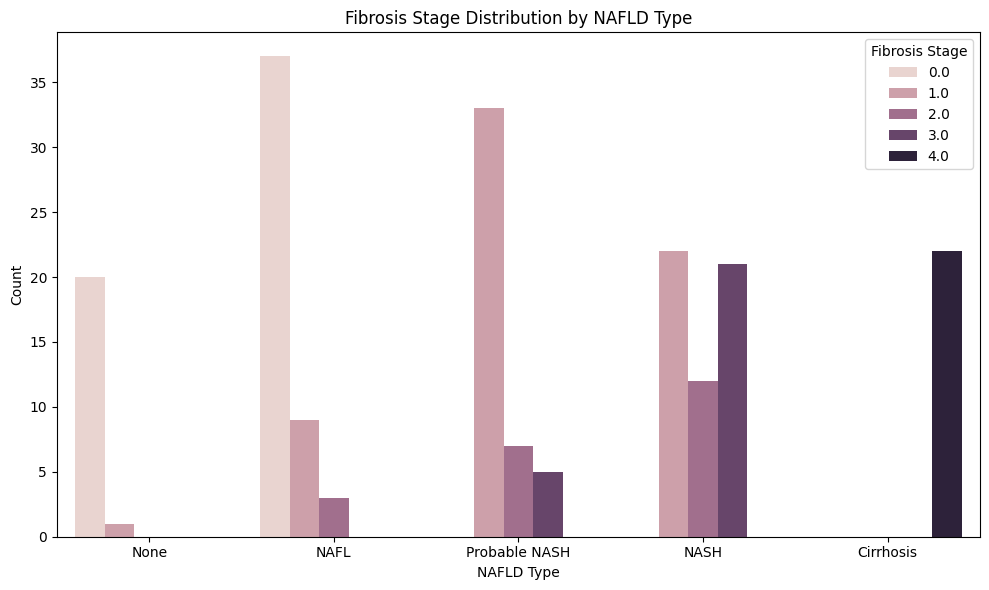

In [556]:
import seaborn as sns
import matplotlib.pyplot as plt

# 원하는 순서로 카테고리 재정의
ordered_types = ["None", "NAFL", "Probable NASH", "NASH", "Cirrhosis"]
data_wFib["NAFLD Type"] = pd.Categorical(
    data_wFib["NAFLD Type"], categories=ordered_types, ordered=True
)

# 시각화
plt.figure(figsize=(10, 6))
sns.countplot(data=data_wFib, x="NAFLD Type", hue="Fibrosis")
plt.title("Fibrosis Stage Distribution by NAFLD Type")
plt.xlabel("NAFLD Type")
plt.ylabel("Count")
plt.legend(title="Fibrosis Stage")
plt.tight_layout()
plt.show()

In [557]:
# fibrosis가 3이면 NASH로 바꾸기

# Step 1: Identify the rows that meet the condition


condition = (data_wFib["NAFLD Type"] == "Probable NASH") & (data_wFib["Fibrosis"] == 3)


# Optional: Check how many rows match


print(f"Rows to update: {condition.sum()}")


# Step 2: Update 'NAFLD Type' to 'NASH' where condition is met


data_wFib.loc[condition, "NAFLD Type"] = "NASH"

Rows to update: 5


In [558]:
# 5160980 5283767 ID인 환자들은 Fibrosis 1로 배정
data_wFib.loc[data_wFib["ID"] == 5160980, "Fibrosis"] = 1
data_wFib.loc[data_wFib["ID"] == 5283767, "Fibrosis"] = 1

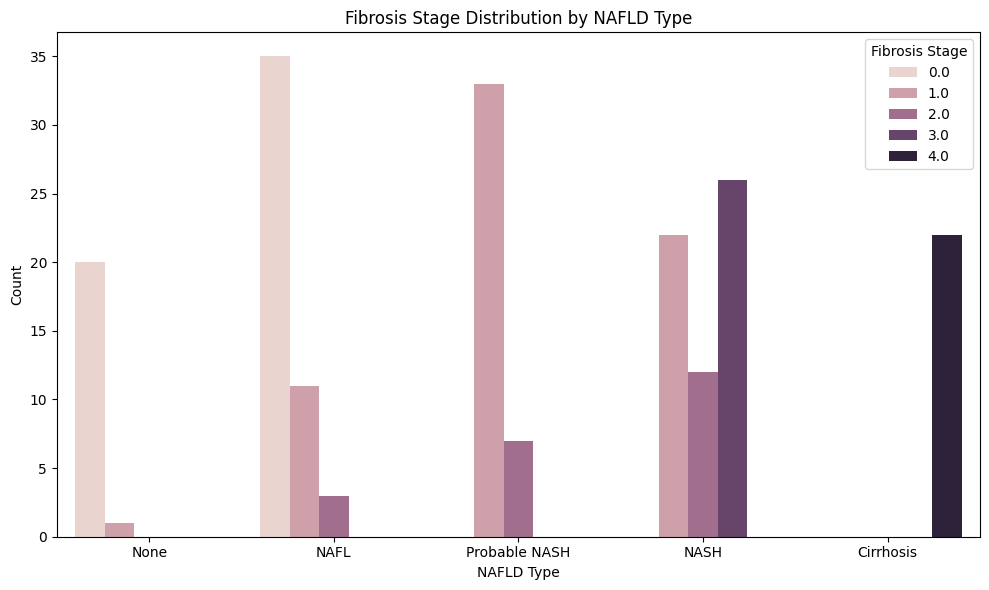

In [559]:
import seaborn as sns
import matplotlib.pyplot as plt

# 원하는 순서로 카테고리 재정의
ordered_types = ["None", "NAFL", "Probable NASH", "NASH", "Cirrhosis"]
data_wFib["NAFLD Type"] = pd.Categorical(
    data_wFib["NAFLD Type"], categories=ordered_types, ordered=True
)

# 시각화
plt.figure(figsize=(10, 6))
sns.countplot(data=data_wFib, x="NAFLD Type", hue="Fibrosis")
plt.title("Fibrosis Stage Distribution by NAFLD Type")
plt.xlabel("NAFLD Type")
plt.ylabel("Count")
plt.legend(title="Fibrosis Stage")
plt.tight_layout()
plt.show()

## 열 정리


In [560]:
main_cols = [
    # 🧠 기본 정보
    "ID",
    "Sex",
    "Birth Date",
    "Age",
    "Death",
    "Death Date",
    "Last F/U",
    "Smoking",
    # 🧬 주요 진단 관련
    "Steatosis Score",
    "Fibrosis",
    "Fibrosis Stage",
    "FIB-4",
    "NAFLD Type",
    "NAFLD Type_C",
    "NASH",
    # 🩺 체형/혈압
    "Weight",
    "Height",
    "BMI",
    "Waist",
    "Waist to Height",
    "SBP",
    "DBP",
    # 🧪 검사 지표
    "AST",
    "ALT",
    "T.bil",
    "PLT",
    "PT INR",
    "Alb",
    "Glucose",
    "HbA1c",
    "eGFR",
    "T.chol",
    "HDL",
    "LDL",
    "TG",
    # 💊 기저질환
    "당뇨병/당뇨병 전단계 유무",
    "고혈압유무",
    "이상지질혈증 유무",
    "Ischemic Heart Diseae 유무",
    "Cerebrovascualr disease 유무",
    "Nephropathy 유무",
    # 🧈 간 영상/탄성/지방
    "LSM",
    "CAP",
    "Liver (PDFF)",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver/Spleen HU",
    "Liver (Volume)",
    "Spleen (Volume)",
    "Liver/Spleen Volume",
    # 🧱 체지방 구성
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    "SMA (Area)",
    "VFA (Attenuation)",
    "SFA (Attenuation)",
    "SMA (Attenuation)",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
    # 🗓 날짜
    "FS_date",
    "CT_B date",
]

event_cols = [
    "LRE",
    "LRE Date",
    "Ascites",
    "Ascites_Date",
    "VB",
    "VB_Date",
    "HEP",
    "HEP_Date",
    "HRS",
    "HRS_Date",
    "LT",
    "LT_Date",
]

In [561]:
# 나머지 (main + event)에 포함 안 된 컬럼들은 그대로 뒤에 둠
others = [col for col in data_wFib.columns if col not in main_cols + event_cols]

# 최종 컬럼 순서
final_col_order = main_cols + others + event_cols

others

[]

In [562]:
# 정렬 적용
data_wFib = data_wFib[final_col_order]

## 중간 저장


In [563]:
import datetime

today = datetime.datetime.now()
today_str = today.strftime("%Y-%m-%d_%H-%M")

save_path = f"{today_str}_mod_2nd Preprocessing.csv"
data_wFib.to_csv(save_path, index=False)

## Steatosis 결측치 채우기


In [564]:
data_wFib = pd.read_csv(save_path, na_values=["", "NaN"], keep_default_na=False)

In [565]:
data_wFib["Steatosis Score"].value_counts(dropna=False)

Steatosis Score
1.0    97
2.0    51
NaN    17
3.0    15
0.0    12
Name: count, dtype: int64

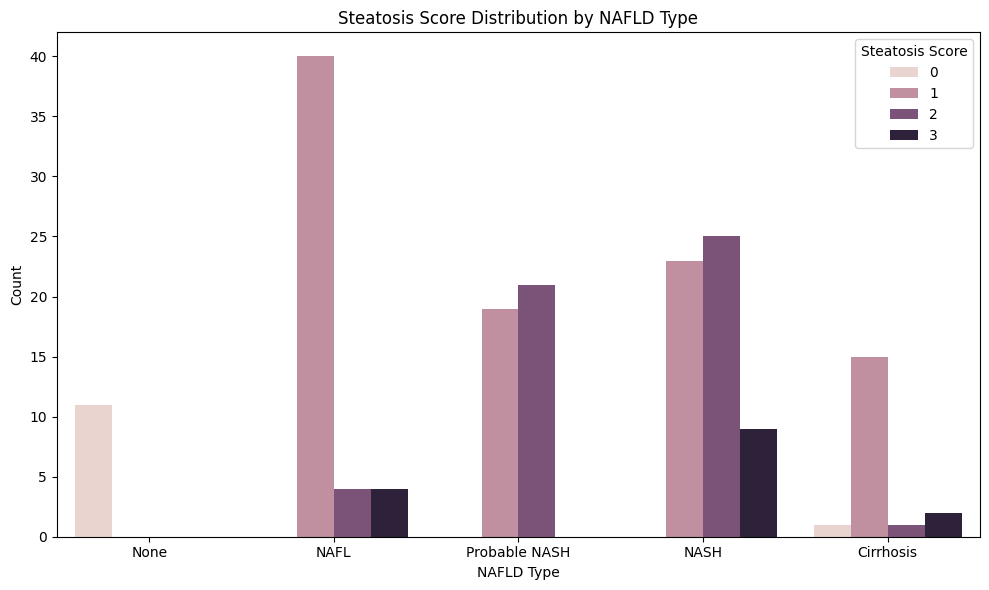

In [566]:
import seaborn as sns
import matplotlib.pyplot as plt

temp_df = data_wFib.copy()
temp_df = temp_df[temp_df["Steatosis Score"].notna()].reset_index(drop=True)
temp_df["Steatosis Score"] = temp_df["Steatosis Score"].astype(int)
# 원하는 순서로 카테고리 재정의
ordered_types = ["None", "NAFL", "Probable NASH", "NASH", "Cirrhosis"]
temp_df["NAFLD Type"] = pd.Categorical(
    temp_df["NAFLD Type"], categories=ordered_types, ordered=True
)

# 시각화
plt.figure(figsize=(10, 6))
sns.countplot(data=temp_df, x="NAFLD Type", hue="Steatosis Score")
plt.title("Steatosis Score Distribution by NAFLD Type")
plt.xlabel("NAFLD Type")
plt.ylabel("Count")
plt.legend(title="Steatosis Score")
plt.tight_layout()
plt.show()

## None NAFLD Type은 Steatosis Score가 0으로 고정되어야 함


In [567]:
data_wFib_wSteatosis = data_wFib.copy()

In [568]:
mask = data_wFib["Steatosis Score"].isna() & (data_wFib["NAFLD Type"] == "None")
data_wFib_wSteatosis.loc[mask, "Steatosis Score"] = 0

In [569]:
data_wFib_wSteatosis["Steatosis Score"].value_counts(dropna=False)

Steatosis Score
1.0    97
2.0    51
0.0    22
3.0    15
NaN     7
Name: count, dtype: int64

In [570]:
def ordinal_soft_impute(df, target, features):
    df = df.copy()
    from statsmodels.miscmodels.ordinal_model import OrderedModel
    from numpy.random import choice

    df = df.dropna(subset=features)
    train = df[~df[target].isna()]
    X_train = train[features]
    y_train = train[target].astype(int)

    model = OrderedModel(y_train, X_train, distr="logit")
    res = model.fit(method="bfgs", disp=False)

    missing_idx = df[df[target].isna()].index
    X_missing = df.loc[missing_idx, features]

    prob_matrix = res.predict(X_missing).values

    # Soft sampling from predicted class probabilities
    imputed = [
        choice(np.arange(prob_matrix.shape[1]), p=prob_matrix[i])
        for i in range(prob_matrix.shape[0])
    ]

    df.loc[missing_idx, target] = imputed
    return df

In [ ]:
data_wFib_wSteatosis["이상지질혈증 유무"] = data_wFib_wSteatosis[
    "이상지질혈증 유무"
].astype(int)

In [572]:
steatosis_features = [
    # 🔸 대사 및 체형 관련
    "BMI",
    "Waist",
    "Waist to Height",
    "Weight",
    "TG",
    "HDL",
    "LDL",
    "T.chol",
    "당뇨병/당뇨병 전단계 유무",
    "이상지질혈증 유무",
    # 🔸 간 지방 직접 측정 또는 대리 지표
    "CAP",
    "Liver (PDFF)",
    "Liver (HU)",
    "Liver/Spleen HU",
    # 🔸 지방 조직 측정값
    "VFA (Volume)",
    "SFA (Volume)",
    "VFI",
    "SFI",
    "TFI",
    # 🔸 기본 인구학
    "Age",
    "Sex",
    "NAFLD Type_C",
]

data_wFib_wSteatosis = ordinal_soft_impute(
    data_wFib_wSteatosis, target="Steatosis Score", features=steatosis_features
)

c:\조나현\연대 의대\연구 생활\이혜원 교수님\data\.venv\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [573]:
data_wFib_wSteatosis["Steatosis Score"].value_counts(dropna=False)

Steatosis Score
1.0    102
2.0     53
0.0     22
3.0     15
Name: count, dtype: int64

In [574]:
import datetime

today = datetime.datetime.now()
today_str = today.strftime("%Y-%m-%d_%H-%M")

save_path = f"{today_str}_mod_wStea_2nd Preprocessing.csv"
data_wFib_wSteatosis.to_csv(save_path, index=False)

## boxplot 그리기


In [577]:
save_path = "./2025-04-20_22-03_mod_wStea_2nd Preprocessing.csv"

data_wFib_wSteatosis = pd.read_csv(
    save_path, na_values=["", "NaN"], keep_default_na=False
)

In [578]:
main_var = [
    "Age",
    "FIB-4",
    "Weight",
    "Height",
    "BMI",
    "Waist",
    "Waist to Height",
    "SBP",
    "DBP",
    "AST",
    "ALT",
    "T.bil",
    "PLT",
    "PT INR",
    "Alb",
    "Glucose",
    "HbA1c",
    "eGFR",
    "T.chol",
    "HDL",
    "LDL",
    "TG",
    "LSM",
    "CAP",
    "Liver (PDFF)",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver/Spleen HU",
    "Liver (Volume)",
    "Spleen (Volume)",
    "Liver/Spleen Volume",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    "SMA (Area)",
    "VFA (Attenuation)",
    "SFA (Attenuation)",
    "SMA (Attenuation)",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
]

main_var_cat = [
    "Sex",
    "당뇨병/당뇨병 전단계 유무",
    "고혈압유무",
    "이상지질혈증 유무",
    "Ischemic Heart Diseae 유무",
    "Cerebrovascualr disease 유무",
    "Nephropathy 유무",
]

## Significant Fibrosis에 대해


In [579]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
import itertools

group_var = "Fibrosis"

# 저장 폴더 생성
folder_path = "./result_images/Significant_Fibrosis_box_group/"
os.makedirs(folder_path, exist_ok=True)

group_labels = ["F0-1", "F2-3", "F4"]  # 그룹 라벨
group_map = lambda x: "F0-1" if x in [0, 1] else "F2-3" if x in [2, 3] else "F4"


for variable in main_var:
    temp_df = data_wFib_wSteatosis.copy()
    temp_df = temp_df[temp_df[[group_var, variable]].notna()].copy()
    temp_df["Fibrosis_group"] = temp_df[group_var].astype(int).map(group_map)

    # Kruskal-Wallis
    grouped = temp_df.groupby("Fibrosis_group")[variable]
    stat, p_kw = kruskal(*[group for name, group in grouped])

    # Boxplot
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(
        data=temp_df,
        x="Fibrosis_group",
        y=variable,
        order=group_labels,
        showfliers=False,
    )
    plt.title(f"{variable} by {group_var} Group\nKruskal-Wallis p = {p_kw:.3e}")
    plt.xlabel(f"{group_var} Group")
    plt.ylabel(variable)

    # Pairwise Mann-Whitney (이웃만)
    comparisons = [
        (group_labels[i], group_labels[i + 1]) for i in range(len(group_labels) - 1)
    ]
    q3 = temp_df[variable].quantile(0.75)
    iqr = q3 - temp_df[variable].quantile(0.25)
    y_max = q3 + 1.5 * iqr
    y_max *= 1.1

    for i, (g1, g2) in enumerate(comparisons):
        data1 = temp_df[temp_df["Fibrosis_group"] == g1][variable]
        data2 = temp_df[temp_df["Fibrosis_group"] == g2][variable]
        if len(data1) < 2 or len(data2) < 2:
            continue
        stat, p = mannwhitneyu(data1, data2)
        if p < 0.001:
            star = "***"
        elif p < 0.01:
            star = "**"
        elif p < 0.05:
            star = "*"
        else:
            star = "ns"
        x1, x2 = group_labels.index(g1), group_labels.index(g2)
        y = y_max + (i + 1) * (y_max * 0.05)
        ax.plot([x1, x1, x2, x2], [y, y + 0.3, y + 0.3, y], lw=1.5, c="k")
        ax.text((x1 + x2) / 2, y + 0.4, star, ha="center", va="bottom", fontsize=12)

    # Save
    filename = f"{variable.replace('/', '_')}_by_{group_var}Group.png"
    plt.tight_layout()
    plt.savefig(
        folder_path + filename,
        dpi=300,
        bbox_inches="tight",
    )
    plt.close()

## 느슨하게 Significant Fibrosis에 대해


In [580]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
import itertools

group_var = "Fibrosis"

# 저장 폴더 생성
folder_path = "./result_images/loose_Significant_Fibrosis_box_group/"
os.makedirs(folder_path, exist_ok=True)

group_labels = ["F0-1", "F2-4"]  # 그룹 라벨
group_map = lambda x: "F0-1" if x in [0, 1] else "F2-4"


for variable in main_var:
    temp_df = data_wFib_wSteatosis.copy()
    temp_df = temp_df[temp_df[[group_var, variable]].notna()].copy()
    temp_df["Fibrosis_group"] = temp_df[group_var].astype(int).map(group_map)

    # Kruskal-Wallis
    grouped = temp_df.groupby("Fibrosis_group")[variable]
    stat, p_kw = kruskal(*[group for name, group in grouped])

    # Boxplot
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(
        data=temp_df,
        x="Fibrosis_group",
        y=variable,
        order=group_labels,
        showfliers=False,
    )
    plt.title(f"{variable} by {group_var} Group\nKruskal-Wallis p = {p_kw:.3e}")
    plt.xlabel(f"{group_var} Group")
    plt.ylabel(variable)

    # Pairwise Mann-Whitney (이웃만)
    comparisons = [
        (group_labels[i], group_labels[i + 1]) for i in range(len(group_labels) - 1)
    ]
    q3 = temp_df[variable].quantile(0.75)
    iqr = q3 - temp_df[variable].quantile(0.25)
    y_max = q3 + 1.5 * iqr
    y_max *= 1.1

    for i, (g1, g2) in enumerate(comparisons):
        data1 = temp_df[temp_df["Fibrosis_group"] == g1][variable]
        data2 = temp_df[temp_df["Fibrosis_group"] == g2][variable]
        if len(data1) < 2 or len(data2) < 2:
            continue
        stat, p = mannwhitneyu(data1, data2)
        if p < 0.001:
            star = "***"
        elif p < 0.01:
            star = "**"
        elif p < 0.05:
            star = "*"
        else:
            star = "ns"
        x1, x2 = group_labels.index(g1), group_labels.index(g2)
        y = y_max + (i + 1) * (y_max * 0.05)
        ax.plot([x1, x1, x2, x2], [y, y + 0.3, y + 0.3, y], lw=1.5, c="k")
        ax.text((x1 + x2) / 2, y + 0.4, star, ha="center", va="bottom", fontsize=12)

    # Save
    filename = f"{variable.replace('/', '_')}_by_{group_var}Group.png"
    plt.tight_layout()
    plt.savefig(
        folder_path + filename,
        dpi=300,
        bbox_inches="tight",
    )
    plt.close()

## Advanced Fibrosis에 대해


In [581]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
import itertools

group_var = "Fibrosis"

# 저장 폴더 생성
folder_path = "./result_images/Advanced_Fibrosis_box_group/"
os.makedirs(folder_path, exist_ok=True)

group_labels = ["F0-2", "F3-4"]  # 그룹 라벨
group_map = lambda x: "F0-2" if x in [0, 1, 2] else "F3-4"


for variable in main_var:
    temp_df = data_wFib_wSteatosis.copy()
    temp_df = temp_df[temp_df[[group_var, variable]].notna()].copy()
    temp_df["Fibrosis_group"] = temp_df[group_var].astype(int).map(group_map)

    # Kruskal-Wallis
    grouped = temp_df.groupby("Fibrosis_group")[variable]
    stat, p_kw = kruskal(*[group for name, group in grouped])

    # Boxplot
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(
        data=temp_df,
        x="Fibrosis_group",
        y=variable,
        order=group_labels,
        showfliers=False,
    )
    plt.title(f"{variable} by {group_var} Group\nKruskal-Wallis p = {p_kw:.3e}")
    plt.xlabel(f"{group_var} Group")
    plt.ylabel(variable)

    # Pairwise Mann-Whitney (이웃만)
    comparisons = [
        (group_labels[i], group_labels[i + 1]) for i in range(len(group_labels) - 1)
    ]
    q3 = temp_df[variable].quantile(0.75)
    iqr = q3 - temp_df[variable].quantile(0.25)
    y_max = q3 + 1.5 * iqr
    y_max *= 1.1

    for i, (g1, g2) in enumerate(comparisons):
        data1 = temp_df[temp_df["Fibrosis_group"] == g1][variable]
        data2 = temp_df[temp_df["Fibrosis_group"] == g2][variable]
        if len(data1) < 2 or len(data2) < 2:
            continue
        stat, p = mannwhitneyu(data1, data2)
        if p < 0.001:
            star = "***"
        elif p < 0.01:
            star = "**"
        elif p < 0.05:
            star = "*"
        else:
            star = "ns"
        x1, x2 = group_labels.index(g1), group_labels.index(g2)
        y = y_max + (i + 1) * (y_max * 0.05)
        ax.plot([x1, x1, x2, x2], [y, y + 0.3, y + 0.3, y], lw=1.5, c="k")
        ax.text((x1 + x2) / 2, y + 0.4, star, ha="center", va="bottom", fontsize=12)

    # Save
    filename = f"{variable.replace('/', '_')}_by_{group_var}_Group.png"
    plt.tight_layout()
    plt.savefig(
        folder_path + filename,
        dpi=300,
        bbox_inches="tight",
    )
    plt.close()

## Severe Steatosis 에 대해


In [582]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
import itertools

group_var = "Steatosis Score"

# 저장 폴더 생성
folder_path = "./result_images/Severe_Steatosis_box_group/"
os.makedirs(folder_path, exist_ok=True)

group_labels = ["S0-1", "S2-3"]  # 그룹 라벨
group_map = lambda x: "S0-1" if x in [0, 1] else "S2-3"


for variable in main_var:
    temp_df = data_wFib_wSteatosis.copy()
    temp_df = temp_df[temp_df[[group_var, variable]].notna()].copy()
    temp_df["Steatosis_group"] = temp_df[group_var].astype(int).map(group_map)

    # Kruskal-Wallis
    grouped = temp_df.groupby("Steatosis_group")[variable]
    stat, p_kw = kruskal(*[group for name, group in grouped])

    # Boxplot
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(
        data=temp_df,
        x="Steatosis_group",
        y=variable,
        order=group_labels,
        showfliers=False,
    )
    plt.title(f"{variable} by {group_var} Group\nKruskal-Wallis p = {p_kw:.3e}")
    plt.xlabel(f"{group_var} Group")
    plt.ylabel(variable)

    # Pairwise Mann-Whitney (이웃만)
    comparisons = [
        (group_labels[i], group_labels[i + 1]) for i in range(len(group_labels) - 1)
    ]
    q3 = temp_df[variable].quantile(0.75)
    iqr = q3 - temp_df[variable].quantile(0.25)
    y_max = q3 + 1.5 * iqr
    y_max *= 1.1

    for i, (g1, g2) in enumerate(comparisons):
        data1 = temp_df[temp_df["Steatosis_group"] == g1][variable]
        data2 = temp_df[temp_df["Steatosis_group"] == g2][variable]
        if len(data1) < 2 or len(data2) < 2:
            continue
        stat, p = mannwhitneyu(data1, data2)
        if p < 0.001:
            star = "***"
        elif p < 0.01:
            star = "**"
        elif p < 0.05:
            star = "*"
        else:
            star = "ns"
        x1, x2 = group_labels.index(g1), group_labels.index(g2)
        y = y_max + (i + 1) * (y_max * 0.05)
        ax.plot([x1, x1, x2, x2], [y, y + 0.3, y + 0.3, y], lw=1.5, c="k")
        ax.text((x1 + x2) / 2, y + 0.4, star, ha="center", va="bottom", fontsize=12)

    # Save
    filename = f"{variable.replace('/', '_')}_by_{group_var}_Group.png"
    plt.tight_layout()
    plt.savefig(
        folder_path + filename,
        dpi=300,
        bbox_inches="tight",
    )
    plt.close()

## Mild Steatosis 에 대해


In [591]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
import itertools

group_var = "Steatosis Score"

# 저장 폴더 생성
folder_path = "./result_images/Mild_Steatosis_box_group/"
os.makedirs(folder_path, exist_ok=True)

group_labels = ["S0", "S1-3"]  # 그룹 라벨
group_map = lambda x: "S0" if x in [0] else "S1-3"


for variable in main_var:
    temp_df = data_wFib_wSteatosis.copy()
    temp_df = temp_df[temp_df[[group_var, variable]].notna()].copy()
    temp_df["Steatosis_group"] = temp_df[group_var].astype(int).map(group_map)

    # Kruskal-Wallis
    grouped = temp_df.groupby("Steatosis_group")[variable]
    stat, p_kw = kruskal(*[group for name, group in grouped])

    # Boxplot
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(
        data=temp_df,
        x="Steatosis_group",
        y=variable,
        order=group_labels,
        showfliers=False,
    )
    plt.title(f"{variable} by {group_var} Group\nKruskal-Wallis p = {p_kw:.3e}")
    plt.xlabel(f"{group_var} Group")
    plt.ylabel(variable)

    # Pairwise Mann-Whitney (이웃만)
    comparisons = [
        (group_labels[i], group_labels[i + 1]) for i in range(len(group_labels) - 1)
    ]
    q3 = temp_df[variable].quantile(0.75)
    iqr = q3 - temp_df[variable].quantile(0.25)
    y_max = q3 + 1.5 * iqr
    y_max *= 1.1

    for i, (g1, g2) in enumerate(comparisons):
        data1 = temp_df[temp_df["Steatosis_group"] == g1][variable]
        data2 = temp_df[temp_df["Steatosis_group"] == g2][variable]
        if len(data1) < 2 or len(data2) < 2:
            continue
        stat, p = mannwhitneyu(data1, data2)
        if p < 0.001:
            star = "***"
        elif p < 0.01:
            star = "**"
        elif p < 0.05:
            star = "*"
        else:
            star = "ns"
        x1, x2 = group_labels.index(g1), group_labels.index(g2)
        y = y_max + (i + 1) * (y_max * 0.05)
        ax.plot([x1, x1, x2, x2], [y, y + 0.3, y + 0.3, y], lw=1.5, c="k")
        ax.text((x1 + x2) / 2, y + 0.4, star, ha="center", va="bottom", fontsize=12)

    # Save
    filename = f"{variable.replace('/', '_')}_by_{group_var}_Group.png"
    plt.tight_layout()
    plt.savefig(
        folder_path + filename,
        dpi=300,
        bbox_inches="tight",
    )
    plt.close()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 시스템에 따라 폰트 설정
if platform.system() == "Windows":
    plt.rcParams["font.family"] = "Malgun Gothic"
elif platform.system() == "Darwin":  # macOS
    plt.rcParams["font.family"] = "AppleGothic"
else:
    plt.rcParams["font.family"] = "NanumGothic"

# 마이너 경고 제거 (음수 부호 깨짐 방지)
plt.rcParams["axes.unicode_minus"] = False

In [ ]:
# 범주형 변수에 대한 그래프래프

for cat_var in main_var_cat:
    temp_df = data_wFib_wSteatosis[[group_var, cat_var]].dropna()
    temp_df[group_var] = temp_df[group_var].astype(int)

    plt.figure(figsize=(8, 5))
    ax = sns.countplot(data=temp_df, x=group_var, hue=cat_var, order=group_order)
    plt.title(f"{cat_var} by Steatosis Score")
    plt.xlabel("Steatosis Score")
    plt.ylabel("Count")
    plt.legend(title=cat_var, loc="upper right")

    safe_var = cat_var.replace("/", "_")  # 🔥 핵심
    filename = f"{safe_var}_by_SteatosisScore_cat.png"
    plt.tight_layout()
    plt.savefig(
        f"./result_images/Steatosis_box/{filename}", dpi=300, bbox_inches="tight"
    )
    plt.close()

In [487]:
import pandas as pd

# 파일 불러오기
df1 = pd.read_csv("./temp.csv")
# df2 = pd.read_csv("./2025-04-20_20-58_mod_wStea_2nd Preprocessing.csv")
df2 = pd.read_csv("./2025-04-20_21-48_mod_wStea_2nd Preprocessing.csv")

var = "Weight"
# 'Fibrosis' 비교
fibrosis_diff = df1[var] != df2[var]
# ID 기준 컬럼명이 '(실명)등록번호'일 경우
diff_df = pd.DataFrame(
    {
        "index": fibrosis_diff[fibrosis_diff].index,
        "ID": df1.loc[fibrosis_diff, "ID"],
        f"{var}_1": df1.loc[fibrosis_diff, var],
        f"{var}_2": df2.loc[fibrosis_diff, var],
    }
).reset_index(drop=True)

diff_df

,index,ID,Weight_1,Weight_2
0,4,1580419,61.00,58.0
1,7,1910122,80.90,82.0
2,12,2215986,80.00,82.0
3,19,2710457,76.05,77.0
4,26,3256005,60.00,62.0
5,33,3664038,78.00,76.0
6,34,3664547,76.00,77.0
7,38,4005110,80.00,80.5
8,53,5108004,94.00,88.0
9,61,5341561,62.00,61.0


In [486]:
import pandas as pd

# 파일 불러오기
df1 = pd.read_csv("./temp.csv")
df2 = pd.read_csv("./2025-04-20_21-48_mod_wStea_2nd Preprocessing.csv")

# 공통 열 중 수치형만
common_cols = df1.columns.intersection(df2.columns)
numeric_cols = [col for col in common_cols if pd.api.types.is_numeric_dtype(df1[col])]

# 수치값 다른 열 목록
diff_cols = [col for col in numeric_cols if (df1[col] != df2[col]).any()]

diff_cols

['Steatosis Score',
 'FIB-4',
 'Weight',
 'Height',
 'BMI',
 'Waist to Height',
 'SBP',
 'DBP',
 'AST',
 'ALT',
 'T.bil',
 'PLT',
 'PT INR',
 'Alb',
 'Glucose',
 'HbA1c',
 'eGFR',
 'T.chol',
 'HDL',
 'LDL',
 'TG',
 '당뇨병/당뇨병 전단계 유무',
 '고혈압유무',
 '이상지질혈증 유무',
 'Ischemic Heart Diseae 유무',
 'LSM',
 'CAP',
 'VFA (Attenuation)',
 'VFI',
 'SFI',
 'TFI',
 'SMI',
 'HRS_Date']